In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# get infinigram frequencies

# read in all NPNs
# with / without acceptability filter

In [17]:
from proj.cxs_are_revealed.paper.data_config import Exp4NPN
from proj.cxs_are_revealed.paper.proj_common.npns import get_npn_data

npn_data = get_npn_data(
    Exp4NPN.npn_gpt_outputs_v2_fixed,
    Exp4NPN.npn_acceptability_v2,
    min_acceptability=4,
    output_has_noun_rep=False,
    do_filter_gpt_generations=False
)
# npn_data_filtered = get_npn_data(
#     Exp6NPN.npn_gpt_outputs,
#     Exp6NPN.npn_acceptability_ratings_csv,
#     # None,
#     output_has_noun_rep=False,
# )


reading from gpt_output_file - before filtering 392
after filtering (did filter = False), 392
392
removed Counter({'rating_by': 46, 'rating_to': 44, 'rating_upon': 33, 'rating_after': 25})
totals after remove Counter({'after': 73, 'upon': 65, 'to': 54, 'by': 52})


In [18]:
len(npn_data)

244

In [19]:
from proj.cxs_are_revealed.paper.proj_common.npn_dataset_generation.npn_utils import GPTOutput
from tqdm import tqdm
from typing import Dict, List
from rozlib.libs.api.api_infinigram import check_infinigram

def get_freq_dict(gpt_outputs: List[GPTOutput]):
    freq_dict: Dict[str, int] = {}
    for npn in tqdm(gpt_outputs):
        tgt_str = f"{npn.noun} {npn.prep} {npn.noun}"
        assert tgt_str.lower() in npn.output.lower()
        try:
            # print(f'check {tgt_str}')
            inf_result = check_infinigram(tgt_str, retries=10, sleep_time=0.4)
            # print(inf_result)
            freq_dict[tgt_str] = inf_result.count
        except Exception as e:
            print(e)
            print('inf query failed')
    return freq_dict

In [20]:
from proj.cxs_are_revealed.paper.cxns_in_distrib import load_dict_from_file

# freqs = get_freq_dict(npn_data)
# save_dict_to_file(freqs, Exp6NPN.npn_infingram)
# save_dict_to_file(freqs, Exp4NPN.npn_roberta_infinigram)
freqs = load_dict_from_file(Exp4NPN.npn_roberta_infinigram)


In [21]:
print(len(freqs.keys()))

392


In [22]:
from pprint import pp

all_res = [(x[0], x[1]) for x in freqs.items()]
pp(sorted(all_res, key=lambda x: x[0]))

[('acronym after acronym', 5),
 ('acronym by acronym', 3),
 ('acronym to acronym', 3),
 ('acronym upon acronym', 3),
 ('ambiguity after ambiguity', 0),
 ('ambiguity by ambiguity', 0),
 ('ambiguity to ambiguity', 4),
 ('ambiguity upon ambiguity', 5),
 ('annoying after annoying', 0),
 ('annoying by annoying', 0),
 ('annoying to annoying', 0),
 ('annoying upon annoying', 0),
 ('asteroid after asteroid', 8),
 ('asteroid by asteroid', 1),
 ('asteroid to asteroid', 100),
 ('asteroid upon asteroid', 0),
 ('automation after automation', 0),
 ('automation by automation', 0),
 ('automation to automation', 4),
 ('automation upon automation', 0),
 ('beginning after beginning', 1),
 ('beginning by beginning', 0),
 ('beginning to beginning', 45),
 ('beginning upon beginning', 0),
 ('bible after bible', 1),
 ('bible by bible', 0),
 ('bible to bible', 9),
 ('bible upon bible', 0),
 ('binge after binge', 13),
 ('binge by binge', 1),
 ('binge to binge', 11),
 ('binge upon binge', 0),
 ('butt after butt'

In [23]:
from collections import Counter
ct = Counter()
for npn in tqdm(npn_data):
    tgt_str = f"{npn.noun} {npn.prep} {npn.noun}"
    f = freqs[tgt_str]
    if f == 0:
        ct[npn.prep] += 1
pp(ct)


100%|██████████| 244/244 [00:00<00:00, 1755420.54it/s]

Counter({'upon': 34, 'after': 15, 'by': 14, 'to': 1})


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def log_binned_hist(data: List[int], init_bucket: int = 1, base: int = 2):
    """
    Plot a histogram with exponentially growing bucket sizes.

    Args:
        data: List of non-negative integers.
        init_bucket: Starting width (e.g., 1 means [1], [2-3], [4-7], ...)
        base: Growth base (e.g., 2 doubles the range each step)
    """
    if not data:
        raise ValueError("Data is empty.")

    data = np.array(data)
    max_val = data.max()

    # Construct bin edges: [1, 2, 4, 8, 16, ...]
    edges = []
    edges.append(0)
    edges.append(1)
    edges.append(10)
    edges.append(50)
    edges.append(100)
    edges.append(1000)
    edges.append(3000)

    # current = init_bucket
    # while current <= max_val:
    #     edges.append(current)
    #     current *= base
    # edges.append(current)  # add upper edge for last bin

    counts, bins = np.histogram(data, bins=edges)

    # Format bin labels
    labels = [f"{int(bins[i])}–{int(bins[i+1])-1}" for i in range(len(bins)-1)]

    plt.figure(figsize=(10, 5))
    # plt.bar(range(len(counts)), counts, tick_label=labels, width=1, align='center')
    bars =     bars = plt.bar(range(len(counts)), counts, tick_label=labels, width=1, align='center')

    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(count),
            ha='center',
            va='bottom',
            fontsize=9
        )
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Value Range (log-scaled buckets)")
    plt.ylabel("Frequency")
    plt.title("Logarithmic Histogram")
    plt.tight_layout()
    plt.show()


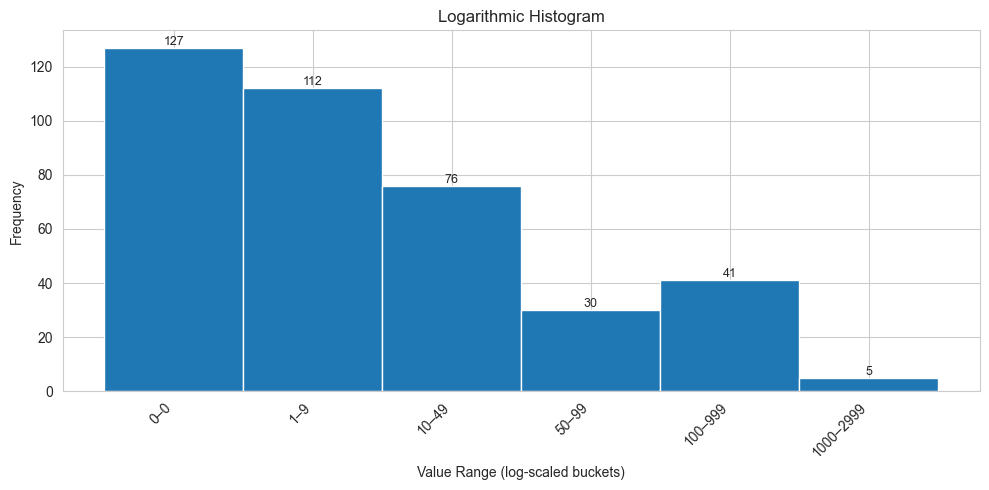

In [25]:

log_binned_hist(list(freqs.values()))

In [29]:
test_npns = [
    'limb from limb',
    'face to face',
    'back to back',
    'day by day',
    'dollar for dollar',
    'book upon book'
]
for t in test_npns:
    res = check_infinigram(t, retries=10, sleep_time=0.4)
    print(t, res.count)


limb from limb 17847
face to face 420845
back to back 125554
day by day 164030
dollar for dollar 12085
book upon book 132
